In [1]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
import time

In [2]:
#to keep things in order, and to avoid to copy and paste everytime our functions if we want to use them in more than one folder,
#we can temporarily use this library. 
import sys

#in this way Python will search the implementations also in the path '../HelperFunctions'
sys.path.insert(0, '../HelperFunctions')


from proj1_helpers import *

In [3]:
yb, input_data, ids = load_csv_data("../Datasets/train.csv")

In [33]:
#this will surely be deleted, in this way we are sure that original_data is the original version of the data and we don't have
#to load them again
from copy import deepcopy
originalData = deepcopy(input_data)


In [34]:
def replaceWithMean(data,invalidValue,idxCols):
    '''Replace the invalidValue with the mean value of the column which it belongs, only in the columns indexed by idxCols. '''
    D = data.shape[1]
    for i in idxCols:
        idxValid = np.where( data[:,i] != invalidValue)
        idxInvalid = np.where( data[:,i] == invalidValue)
        mean = np.mean( data[idxValid,i] )
        data[idxInvalid,i] = mean
    return data

def replaceWithZero(data,invalidValue,idxCols):
    '''Replace the invalidValue with 0, only in the columns indexed by idxCols. '''
    D = data.shape[1]
    for i in idxCols:
        idxInvalid = np.where( data[:,i] == invalidValue)
        data[idxInvalid,i] = 0
    return data

In [35]:
def countInvalid(data, invalidValue):
    '''Returns an array of length D, each elements counts how many invalidValue(s) there are in the column'''
    D = data.shape[1]
    counter = np.array( [ (data[:,i] == invalidValue).sum() for i in range(D) ] )
    return counter

In [36]:
numInvalidValues = countInvalid(originalData,-999)
print(numInvalidValues)

[ 38114      0      0      0 177457 177457 177457      0      0      0
      0      0 177457      0      0      0      0      0      0      0
      0      0      0  99913  99913  99913 177457 177457 177457      0]


As you can see, there are only some columns where there are invalid values.


The first one is an estimated measure of the mass of the boson, it has been replaced with -999 when the estimation gave a bad result.


The other variables are set to -999 when they makes no sense. For instance when they refer to the different between 2 things and in the experiment there is only one thing (e.g one jet vs 2 jets, column 5).


This leads to a different interpretation of the missing values and to a different way to treat them. I think that substituting the mean value of the column makes no sense for "the second type of missing value" (e.g column 5), while it could be correct for the column related to the mass. <br>
For instance in the case of column 5 it makes no sense to talk about the difference between 2 jets when in the experiment there is only one jet. Hence, it could be more reasonable to put a arbitrary value like 0 instead of trying to deduce a value from the experiments with 2 jets. 0 could work as a more appropriate "flag" wrt to -999, that indicates the experiment with only 1 jet. 


In [37]:
numInvalidValues/250000

array([0.152456, 0.      , 0.      , 0.      , 0.709828, 0.709828,
       0.709828, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.709828, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.399652,
       0.399652, 0.399652, 0.709828, 0.709828, 0.709828, 0.      ])

Since in the first columns there are only 15% of datas that are missing, maybe we can simply avoid to consider them in the dataset. This shouldn't be a great loss and it allows us to avoid thinking about how to substituite -999 in this case, which is also the most complicated

Firstly, I will try to substitute the -999 with the mean value of the column for the column related to the mass, to see what happen. While, for the variables in the column different from the first one, I will put 0.

In [38]:
#recover original data
input_data = deepcopy(originalData)

#Let's put 0 in the -999 generated by the "no sense" variable
idxCols = np.where(numInvalidValues>0)[0]
input_data = replaceWithZero(input_data,-999,idxCols[1:])

#Let's put the mean of the computed masses instead of -999
input_data = replaceWithMean(input_data,-999,[0])

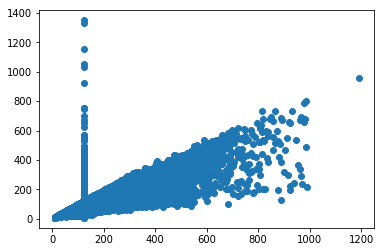

In [39]:
plt.scatter(input_data[:,0],input_data[:,2])


The results are not so good, the mean values of the mass seems to behave as outliers..

Another way to proceed to substitute the -999 in the mass, could be to do a "simple" least squares regression to predict the value of the mass using the other 29 features. We have tried to do this and the "outlier problem" seems to disappear.

This approach is suggested in some online articles, but I don't like it too much for a couple of reasons: <br>
1) usually the features are thought to be independent, hence doing a regression to discover the value of a feature based on the values of the other features could provide a result that doesn't describe a real/physics correlation between the features. Since we don't know well our features, maybe it isn't a good idea to suppose that there is such a correlation that allows us to predict the missing mass values <br>
2) we have onlt 15% of missing mass values, introduce such a complication for this relative small portion of data could be worthless


Hence, at the end, I think that the best way to proceed is to delete the rows related to the missing mass values. For the other missing values, with 0 instead of -999, the scatterplots aren't so shitty so this could really be a good choice.

In [40]:
def removeLines(data, idxCol, invalidValue):
    '''Remove the lines in data that contains invalidValue in position idxCol'''
    idx = np.where(data[:,idxCol] == invalidValue)
    data = np.delete(data,idx,axis=0)
    return data

In [41]:
#recover originalData
input_data = deepcopy(originalData)

#remove the lines whose mass is -999
input_data = removeLines(input_data,0,-999)

#in the remaining part of the dataset, replace the -999 with the mean
idxCols = np.where(numInvalidValues>0)[0]
input_data = replaceWithZero(input_data,-999,idxCols)
input_data.shape

(211886, 30)

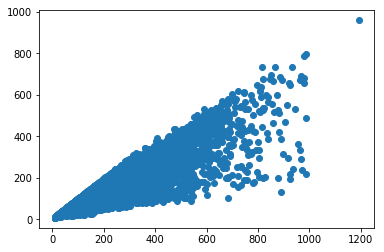

In [42]:
plt.scatter(input_data[:,0],input_data[:,2])

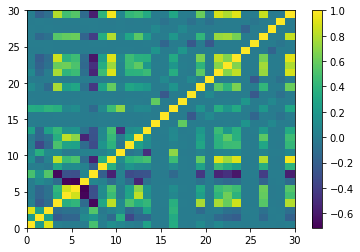

(array([ 0,  2,  3,  3,  3,  4,  4,  5,  9,  9,  9,  9, 12, 21, 21, 21, 23,
        23, 23, 23, 26, 29, 29, 29, 29, 29], dtype=int64),
 array([ 2,  0,  9, 23, 29,  5, 12,  4,  3, 21, 23, 29,  4,  9, 23, 29,  3,
         9, 21, 29, 29,  3,  9, 21, 23, 26], dtype=int64))

In [44]:
import pylab

# plotting the correlation matrix
R = np.corrcoef(input_data.T)
pylab.pcolor(R)
pylab.colorbar()
pylab.show()

np.where( (0.8 < R) & (R < 0.98))